In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from surprise import Dataset, Reader, NormalPredictor, KNNBasic, KNNWithZScore, KNNWithMeans, KNNWithZScore, SVD
from surprise.model_selection import train_test_split, cross_validate
from collections import defaultdict
from surprise import accuracy
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
# df_review = pd.read_csv("yelp_academic_dataset_review.csv")
# df_review = pd.DataFrame(df_review)

In [4]:
# df_business = pd.read_csv("yelp_academic_dataset_business.csv")
# df_business = pd.DataFrame(df_business)

In [3]:
df_user = pd.read_csv("yelp_academic_dataset_user.csv")
df_user = pd.DataFrame(df_user)

C:\Users\asus\AppData\Local\Temp\ipykernel_20128\1230748970.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_user = pd.read_csv("yelp_academic_dataset_user.csv")


In [13]:
df_user.head(2)

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946


In [ ]:
pip install pandas networkx matplotlib


VAMOS CRIAR UMA COMUNIDADE DE USERS COM BASE NOS AMIGOS DELES :)))

KeyboardInterrupt: 

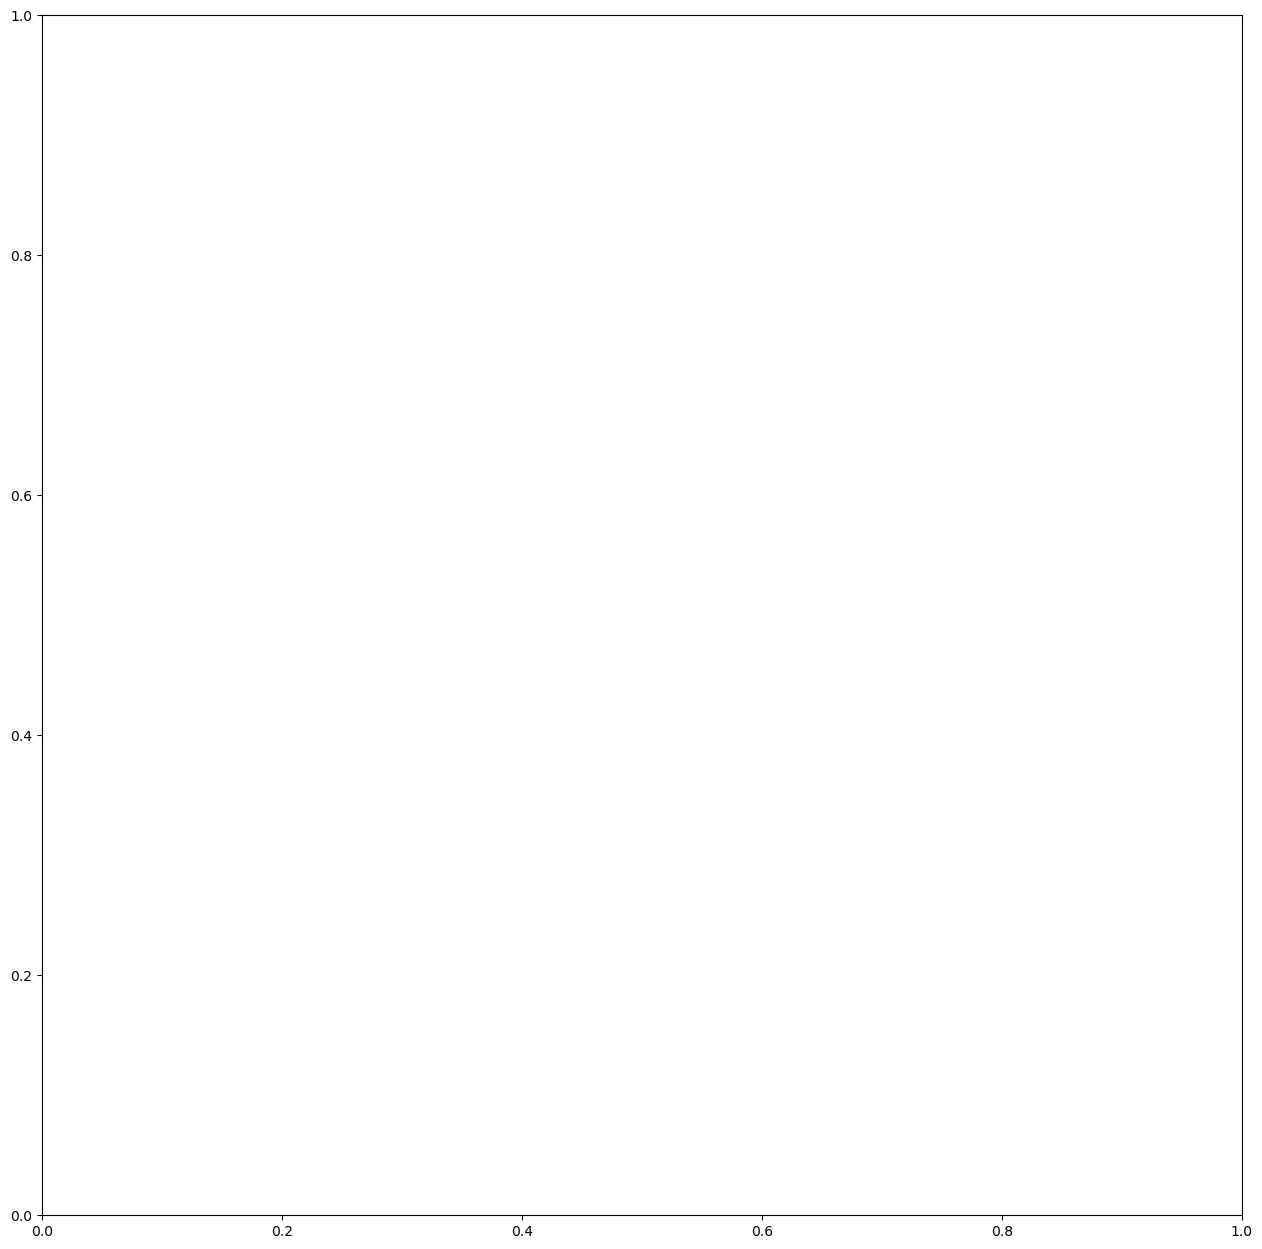

In [12]:
G = nx.Graph()

df_user_filtered = df_user.head(10)

# Iterate over each row to create edges for friendships

for idx, row in df_user_filtered.iterrows():
# for idx, row in df_user.iterrows():
    user_id = row['user_id']
    friends = row['friends']
    
    # Split the friends string into a list
    if isinstance(friends, str):  # Ensure it’s not NaN
        friends_list = friends.split(', ')
        for friend_id in friends_list:
            G.add_edge(user_id, friend_id)  # Create an edge between user and each friend

# Draw the graph
plt.figure(figsize=(12, 12))
nx.draw(G, with_labels=False, node_size=20, edge_color="gray", alpha=0.6, node_color="blue")
plt.show()


45 min e não acabou

In [ ]:
# Draw the graph
plt.figure(figsize=(12, 12))
nx.draw(G, with_labels=False, node_size=20, edge_color="gray", alpha=0.6, node_color="blue")
plt.show()

70 min e não acabou. Não vale a pena repetir, temos de simplificar

In [ ]:
node_size = [G.degree(node) * 10 for node in G.nodes()]

# Draw the graph with variable node sizes
plt.figure(figsize=(12, 12))
nx.draw(G, with_labels=False, node_size=node_size, edge_color="gray", alpha=0.6, node_color="blue")
plt.show()

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Filter the first 100 users
df_user_filtered = df_user.head(10)

# Create a set of user IDs in the filtered dataset for quick lookup
user_ids_set = set(df_user_filtered['user_id'])

# Initialize an empty graph
G = nx.Graph()

# Create a list of edges
edges = []

# Iterate over each row to create edges for friendships
for idx, row in df_user_filtered.iterrows():
    user_id = row['user_id']
    friends = row['friends']
    
    # Split the friends string into a list
    if isinstance(friends, str):  # Ensure it’s not NaN
        friends_list = friends.split(', ')
        # Add edges only for friends who are in the filtered dataset
        for friend_id in friends_list:
            if friend_id in user_ids_set:
                edges.append((user_id, friend_id))  # Collect edges in a list

# Add all edges to the graph at once
G.add_edges_from(edges)

# Draw the graph
plt.figure(figsize=(12, 12))
nx.draw(G, with_labels=False, node_size=20, edge_color="gray", alpha=0.6, node_color="blue")
plt.show()






#previous code